In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

In [ ]:
class MostLikelySymbol(Layer):
    """Return the most likely symbol from a softmax input in the
    one hot encoded form.

    This layer is only active at test time as otherwise it would
    stop gradient propogation during training. Also it is useful
    to train with a softmax output to encourage a decisive 
    decision and because it means you can assess confidence.

    # Arguments
        None

    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.

    # Output shape
        Same shape as input.
    """

    def __init__(self, **kwargs):
        super(MostLikelySymbol, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
        def most_likely():
            max_vals = K.max(inputs, axis=1, keepdims=True) 
            max_vals = K.cast(max_vals, 'float32')
            geT = K.greater_equal(inputs, max_vals)
            return K.cast(geT, 'float32')            
        return K.in_train_phase(inputs, most_likely, training=training)

    def get_config(self):
        config = {}
        base_config = super(MostLikelySymbol, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from keras.layers import Input, Dense, Lambda, Add, GaussianNoise, ActivityRegularization
from keras.models import Model
from keras.layers import BatchNormalization 
from keras import backend as K
from keras.layers import advanced_activations
from keras.layers import Layer
from keras.initializers import Zeros as kZeros
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
#from keras.utils import multi_gpu_model

import numpy as np
from numpy.random import seed
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.stats import norm
from tqdm import tqdm_notebook, tnrange
from time import time
import random as rd

import matplotlib.pyplot as plt

seed(5)
tf.random.set_seed(3.8)

In [ ]:
print(keras.__version__)

2.7.0


# **DATASET**

In [3]:
#total_size = 1000000
#func_data, file_path, all_one_hot_messages = get_data_set(256, total_size)
data22 = np.load('./drive/MyDrive/Colab-Notebooks/data/data4.npy')
#print(data.shape)

# Test Data
train_data22, test_data22 = train_test_split(data22, \
                                          train_size=0.8)

# # # Train and Validation
train_data22, valid_data22 = train_test_split(train_data22, \
                                          train_size=0.9)

In [4]:
train_data22.shape, valid_data22.shape, test_data22.shape

((720000, 4), (80000, 4), (200000, 4))

In [ ]:
#total_size = 1000000
#func_data, file_path, all_one_hot_messages = get_data_set(256, total_size)
data44 = np.load('./drive/MyDrive/Colab-Notebooks/data/data16.npy')
#print(data.shape)

# Test Data
train_data44, test_data44 = train_test_split(data44, \
                                          train_size=0.8)

# # # Train and Validation
train_data44, valid_data44 = train_test_split(train_data44, \
                                          train_size=0.9)

In [ ]:
#total_size = 1000000
#func_data, file_path, all_one_hot_messages = get_data_set(256, total_size)
data88 = np.load('./drive/MyDrive/Colab-Notebooks/data/data256.npy')
#print(data.shape)

# Test Data
train_data88, test_data88 = train_test_split(data88, \
                                          train_size=0.8)

# # # Train and Validation
train_data88, valid_data88 = train_test_split(train_data88, \
                                          train_size=0.9)

In [ ]:
# Verifique o train loss e ajuste a taxa de aprendizagem de acordo com a perda. 
# Ajuste a epoch e batch_size, e batch_size deve ser o maior possível, para que o 
# efeito de aprendizagem seja bom.

# **NEW MODEL AND FIT**

In [ ]:
act_f = advanced_activations.LeakyReLU()
act_f.__name__ = 'leakyrelu'

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
# CUSTOM CLASS PARA SNR TREINO VARIAVEL
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, decreasingSNR=7, logs=None):
    # ebn0_ = np.arange(0,9,1)
    # rand_index = rd.randint(0, ebn0_.shape[0]-1)
    # snr = ebn0_[rand_index]
    EbNo_train = 10**(decreasingSNR/10)
    EbNo_train = np.sqrt(1/(2*R*EbNo_train))
    self.model.layers[5].stddev = EbNo_train
    #print('updating sttdev in training')
    print('SNR treino: ', self.model.layers[5].stddev)

In [ ]:
# TRAINING AUTOENCODER - Building the model 

def make_model(M, R, n_ch, snr_treino=5):
  input_signal = Input(shape=(M,))
  dense1 = Dense(M, activation=act_f)(input_signal)
  dense2 = Dense(2*n_channel, activation='linear')(dense1)

  encoded2 = BatchNormalization()(dense2)
  encoded3 = Lambda(lambda x: np.sqrt(n_ch)*K.l2_normalize(x,axis=1))(encoded2)

  # SNR de treino
  #snr_treino = 7
  EbNo_train = 10**(snr_treino/10)                                              # converting from dB to linear
  noise = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)
  
  #denseDecoded1 = Dense(M, activation='relu')(noise)
  denseDecoded2 = Dense(M, activation=act_f)(noise)
  decoded1 = Dense(M, activation='softmax')(denseDecoded2)

  autoencoder = Model(input_signal, decoded1)
  #sgd = SGD(lr=0.001)
  autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')


  encoder = Model(input_signal, encoded3)

  # making decoder from full autoencoder
  encoded_input = Input(shape=(2*int(n_ch),))
  deco = autoencoder.layers[-2](encoded_input)
  deco = autoencoder.layers[-1](deco)
  decoder = Model(encoded_input, deco)
                      

  # .fit(data,data,...) because is an Autoencoder: input and target must be (almost) the same.
  # noise_change = MyCustomCallback()
  # for epoch_batch in range(10):
  #   snr_decrease = np.arange(9, -1, -1)
  #   for epoch in range(10):
  #     print('Epoch {}/{}/100'.format(epoch+1, epoch_batch+1))    
  #     autoencoder.fit(train_data44, train_data44,
  #                     epochs=1,
  #                     batch_size=2000,
  #                     validation_data=(valid_data44, valid_data44),
  #                     callbacks=[noise_change])
      
  #     noise_change.on_epoch_begin(decreasingSNR=snr_decrease[epoch_batch])
  
  return autoencoder, encoder, decoder

#⚡**R=1/2**

# M=16 

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16  

k = np.log2(M) #4
k = int(k)

# Channel uses
n = 8 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_48, tx48, rx48 = make_model(16, R, n_channel, 5)

ae_48.fit(train_data44, train_data44,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data44, valid_data44),
                      callbacks=[es])

Epoch 1/100
360/360 [==============================] - 1s 3ms/step - loss: 0.9084 - val_loss: 0.0495
Epoch 2/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0859 - val_loss: 0.0046
Epoch 3/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0412 - val_loss: 0.0011
Epoch 4/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0283 - val_loss: 3.5251e-04
Epoch 5/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 1.3306e-04
Epoch 6/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 5.8258e-05
Epoch 7/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 2.5239e-05
Epoch 8/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0146 - val_loss: 1.2328e-05
Epoch 9/100
360/360 [==============================] - 1s 2ms/step - loss: 0.0140 - val_loss: 6.2767e-06
Epoch 10/100
360/360 [==============================] - 1s 2ms/step

In [ ]:
### SAVING MODEL
ae_48.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae48_5_b2000.model')
ae_48.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae48_5_b2000.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae48_5_b2000.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae48_5_b2000.model/assets


In [ ]:
# TESTING AUTOENCODER
test_dim1 = test_data44.shape[0]

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber16 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim1       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    encoded_signal = tx48.predict(test_data44) 
    #print(encoded_signal.shape)

    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx48.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber16[n] = no_errors #/ nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber16[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.327845
SNR: -1 BER: 0.24802
SNR: 0 BER: 0.17343
SNR: 1 BER: 0.108535
SNR: 2 BER: 0.058465
SNR: 3 BER: 0.026585
SNR: 4 BER: 0.009575
SNR: 5 BER: 0.00267
SNR: 6 BER: 0.000555
SNR: 7 BER: 0.0001
SNR: 8 BER: 1e-05
SNR: 9 BER: 0.0
SNR: 10 BER: 0.0


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-48-b2000.npy', 'wb') as f:
  np.save(f, ber16)

## M = 16 - Execution Time

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16  

k = np.log2(M) #4
k = int(k)
# Channel uses
n = 8 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_48, tx48, rx48 = make_model(16, R, n_channel, 5)
ae_48.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae48_5_b2000.h5')

test_dim1 = test_data44.shape[0]
time_taken = []

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber16 = [None]*len(EbNodB_range)
time_taken = [None]*len(EbNodB_range)

for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim1       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    start = time()
    encoded_signal = tx48.predict(test_data44) 
    #print(encoded_signal.shape)
    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx48.predict(final_signal))
    finish = time()

    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    #no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    #ber16[n] = no_errors #/ nn
    time_taken[n] = finish-start 
    print('SNR:', EbNodB_range[n])
    print("Elapsed time for Encode and Decode: {}s".format(finish-start))
    print("Elapsed time by message encoded/decoded: {}s".format((finish-start)/test_dim1))
    print("\n")


SNR: -2
Elapsed time for Encode and Decode: 9.693797588348389s
Elapsed time by message encoded/decoded: 4.846898794174194e-05s


SNR: -1
Elapsed time for Encode and Decode: 9.478955745697021s
Elapsed time by message encoded/decoded: 4.7394778728485105e-05s


SNR: 0
Elapsed time for Encode and Decode: 9.687835931777954s
Elapsed time by message encoded/decoded: 4.843917965888977e-05s


SNR: 1
Elapsed time for Encode and Decode: 9.572566509246826s
Elapsed time by message encoded/decoded: 4.786283254623413e-05s


SNR: 2
Elapsed time for Encode and Decode: 9.531346797943115s
Elapsed time by message encoded/decoded: 4.765673398971558e-05s


SNR: 3
Elapsed time for Encode and Decode: 9.472483396530151s
Elapsed time by message encoded/decoded: 4.736241698265076e-05s


SNR: 4
Elapsed time for Encode and Decode: 9.52745771408081s
Elapsed time by message encoded/decoded: 4.7637288570404054e-05s


SNR: 5
Elapsed time for Encode and Decode: 9.404690742492676s
Elapsed time by message encoded/decoded

In [ ]:
(sum(time_taken)/len(time_taken))/test_dim1

4.7778770831915044e-05

In [ ]:
constellation_48 = tx48.predict(test_data44) 

In [ ]:
constellation_48.shape

(200000, 16)

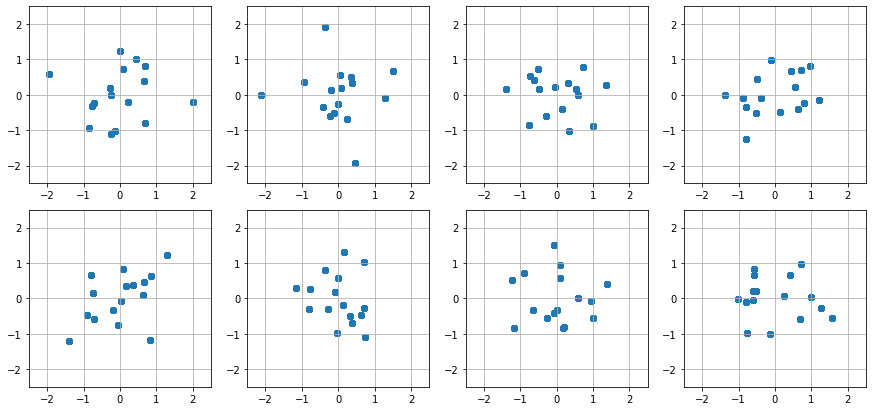

<Figure size 720x576 with 0 Axes>

In [ ]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4)
plt.figure(figsize=(10,8))
fig.set_figheight(7)
fig.set_figwidth(15)
#fig.suptitle('Horizontally stacked subplots')

cluster = ['.','^','p','P','s','o','*','x','.','.','.','.','.','.','.','.']
#colors = ['']

ax1.scatter(constellation_48[:,0], constellation_48[:,1], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax2.scatter(constellation_48[:,2], constellation_48[:,3], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax3.scatter(constellation_48[:,4], constellation_48[:,5], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax4.scatter(constellation_48[:,6], constellation_48[:,7], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax5.scatter(constellation_48[:,8], constellation_48[:,9], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax6.scatter(constellation_48[:,10], constellation_48[:,11], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax7.scatter(constellation_48[:,12], constellation_48[:,13], zorder=1, s=30,alpha=1.0)#, marker=cluster)
ax8.scatter(constellation_48[:,14], constellation_48[:,15], zorder=1, s=30,alpha=1.0)#, marker=cluster)

ax1.axis((-2.5,2.5,-2.5,2.5))
ax1.grid()
ax2.axis((-2.5,2.5,-2.5,2.5))
ax2.grid()
ax3.axis((-2.5,2.5,-2.5,2.5))
ax3.grid()
ax4.axis((-2.5,2.5,-2.5,2.5))
ax4.grid()
ax5.axis((-2.5,2.5,-2.5,2.5))
ax5.grid()
ax6.axis((-2.5,2.5,-2.5,2.5))
ax6.grid()
ax7.axis((-2.5,2.5,-2.5,2.5))
ax7.grid()
ax8.axis((-2.5,2.5,-2.5,2.5))
ax8.grid()
fig.subplots_adjust(hspace=0.15, wspace=0.2)
plt.show()

In [ ]:
fig.savefig('./drive/MyDrive/Colab_Notebooks/figures/Coded/const-m16n8.jpeg')

# M=256

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 256  

k = np.log2(M) #4
k = int(k)

# Channel uses
n = 16 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_816, tx816, rx816 = make_model(M, R, n_channel, 2)

ae_816.fit(train_data88, train_data88,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data88, valid_data88),
                      callbacks=[es])

Epoch 1/100
360/360 [==============================] - 4s 6ms/step - loss: 0.9182 - val_loss: 3.9827e-04
Epoch 2/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1780 - val_loss: 1.5840e-05
Epoch 3/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1544 - val_loss: 2.6077e-06
Epoch 4/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1456 - val_loss: 8.0527e-07
Epoch 5/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1407 - val_loss: 3.1860e-07
Epoch 6/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1377 - val_loss: 1.5051e-07
Epoch 7/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1348 - val_loss: 8.7546e-08
Epoch 8/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1341 - val_loss: 6.0998e-08
Epoch 9/100
360/360 [==============================] - 2s 5ms/step - loss: 0.1337 - val_loss: 5.0271e-08
Epoch 10/100
360/360 [==============================] -

In [ ]:
### SAVING MODEL
ae_816.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae816_2_b2000.model')
ae_816.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae816_2_b2000.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae816_2_b2000.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae816_2_b2000.model/assets


In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 256  

k = np.log2(M) #8
k = int(k)
# Channel uses
n = 16 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_816, tx816, rx816 = make_model(256, R, n_channel, 5)
ae_816.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae816_5_b2000.h5')

test_dim1 = test_data88.shape[0]
time_taken = []

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber256 = [None]*len(EbNodB_range)
time_taken = [None]*len(EbNodB_range)

for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim1       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    start = time()
    encoded_signal = tx816.predict(test_data88) 
    #print(encoded_signal.shape)
    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx816.predict(final_signal))
    finish = time()

    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    #no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    #ber16[n] = no_errors #/ nn
    time_taken[n] = finish-start 
    print('SNR:', EbNodB_range[n])
    print("Elapsed time for Encode and Decode: {}s".format(finish-start))
    print("Elapsed time by message encoded/decoded: {}s".format((finish-start)/test_dim1))
    print("\n")


SNR: -2
Elapsed time for Encode and Decode: 10.09518313407898s
Elapsed time by message encoded/decoded: 5.0475915670394895e-05s


SNR: -1
Elapsed time for Encode and Decode: 9.786085367202759s
Elapsed time by message encoded/decoded: 4.8930426836013793e-05s


SNR: 0
Elapsed time for Encode and Decode: 9.984347581863403s
Elapsed time by message encoded/decoded: 4.9921737909317016e-05s


SNR: 1
Elapsed time for Encode and Decode: 10.049221277236938s
Elapsed time by message encoded/decoded: 5.024610638618469e-05s


SNR: 2
Elapsed time for Encode and Decode: 9.96105408668518s
Elapsed time by message encoded/decoded: 4.9805270433425906e-05s


SNR: 3
Elapsed time for Encode and Decode: 9.827538251876831s
Elapsed time by message encoded/decoded: 4.913769125938415e-05s


SNR: 4
Elapsed time for Encode and Decode: 10.00862193107605s
Elapsed time by message encoded/decoded: 5.004310965538025e-05s


SNR: 5
Elapsed time for Encode and Decode: 9.816542387008667s
Elapsed time by message encoded/deco

In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-816-2-b2000.npy', 'wb') as f:
  np.save(f, ber256)

## M = 256 - Execution Time

In [ ]:

# TESTING AUTOENCODER
test_dim1 = test_data44.shape[0]

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber16 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim1       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    encoded_signal = tx48.predict(test_data44) 
    #print(encoded_signal.shape)

    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx48.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber16[n] = no_errors #/ nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber16[n])

#⚡**R=1/3**

#M=16, k=4, n=12

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16  

k = np.log2(M) #4
k = int(k)

# Channel uses
n = 12 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_412, tx412, rx412 = make_model(16, R, n_channel, 5)

ae_412.fit(train_data44, train_data44,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data44, valid_data44),
                      callbacks=[es])

Epoch 1/100
360/360 [==============================] - 4s 4ms/step - loss: 0.7735 - val_loss: 0.0248
Epoch 2/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0686 - val_loss: 0.0025
Epoch 3/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0358 - val_loss: 5.6328e-04
Epoch 4/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0253 - val_loss: 1.7293e-04
Epoch 5/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0200 - val_loss: 6.2656e-05
Epoch 6/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0172 - val_loss: 2.6134e-05
Epoch 7/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0154 - val_loss: 1.1993e-05
Epoch 8/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0139 - val_loss: 5.3685e-06
Epoch 9/100
360/360 [==============================] - 2s 4ms/step - loss: 0.0133 - val_loss: 2.8185e-06
Epoch 10/100
360/360 [==============================] - 2s 5ms/

In [ ]:
### SAVING MODEL
ae_412.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae412_5_b2000.model')
ae_412.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae412_5_b2000.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae412_5_b2000.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae412_5_b2000.model/assets


In [ ]:
# TESTING AUTOENCODER
test_dim1 = test_data44.shape[0]

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber412 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim1       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    encoded_signal = tx412.predict(test_data44) 
    #print(encoded_signal.shape)

    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx412.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber412[n] = no_errors #/ nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber412[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.328115
SNR: -1 BER: 0.24536
SNR: 0 BER: 0.17159
SNR: 1 BER: 0.10615
SNR: 2 BER: 0.05818
SNR: 3 BER: 0.02609
SNR: 4 BER: 0.00974
SNR: 5 BER: 0.00268
SNR: 6 BER: 0.00046
SNR: 7 BER: 6.5e-05
SNR: 8 BER: 1e-05
SNR: 9 BER: 0.0
SNR: 10 BER: 0.0


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-412-b2000.npy', 'wb') as f:
  np.save(f, ber412)

#M=256, k=8, n=24

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 256  

k = np.log2(M) #4
k = int(k)

# Channel uses
n = 24 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_824, tx824, rx824 = make_model(M, R, n_channel, 5)

ae_824.fit(train_data88, train_data88,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data88, valid_data88),
                      callbacks=[es])

Epoch 1/100
360/360 [==============================] - 3s 6ms/step - loss: 0.5404 - val_loss: 5.4710e-04
Epoch 2/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0146 - val_loss: 5.0739e-05
Epoch 3/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 9.9927e-06
Epoch 4/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0056 - val_loss: 2.7067e-06
Epoch 5/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0043 - val_loss: 8.5150e-07
Epoch 6/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0039 - val_loss: 2.2844e-07
Epoch 7/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 5.1917e-08
Epoch 8/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0030 - val_loss: 8.6740e-09
Epoch 9/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 1.8775e-10
Epoch 10/100
360/360 [==============================] -

In [ ]:
### SAVING MODEL
ae_824.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae824_5_b2000.model')
ae_824.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae824_5_b2000.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae824_5_b2000.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae824_5_b2000.model/assets


In [ ]:
# TESTING AUTOENCODER
test_dim2 = test_data88.shape[0]

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber824 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim2       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    encoded_signal = tx824.predict(test_data88) 
    #print(encoded_signal.shape)

    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx824.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data88).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber824[n] = no_errors #/ nn 
    print('SNR:',EbNodB_range[n],'BER:',ber824[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.460595
SNR: -1 BER: 0.33634
SNR: 0 BER: 0.217625
SNR: 1 BER: 0.118945
SNR: 2 BER: 0.05265
SNR: 3 BER: 0.01691
SNR: 4 BER: 0.00433
SNR: 5 BER: 0.00071
SNR: 6 BER: 7.5e-05
SNR: 7 BER: 0.0
SNR: 8 BER: 0.0
SNR: 9 BER: 0.0
SNR: 10 BER: 0.0


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-824-b2000.npy', 'wb') as f:
  np.save(f, ber824)

#⚡(7,4) - R = 4/7
#M=16, k=4, n=7

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16  

k = np.log2(M) #4
k = int(k)

# Channel uses
n = 7 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

ae_74, tx74, rx74 = make_model(M, R, n_channel, 5)

ae_74.fit(train_data44, train_data44,
                      epochs=100,
                      batch_size=2000,
                      validation_data=(valid_data44, valid_data44),
                      callbacks=[es])

Epoch 1/100
360/360 [==============================] - 2s 4ms/step - loss: 0.8773 - val_loss: 0.0669
Epoch 2/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0986 - val_loss: 0.0069
Epoch 3/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0470 - val_loss: 0.0017
Epoch 4/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0313 - val_loss: 5.4129e-04
Epoch 5/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0241 - val_loss: 2.0089e-04
Epoch 6/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0197 - val_loss: 8.2540e-05
Epoch 7/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0171 - val_loss: 3.6180e-05
Epoch 8/100
360/360 [==============================] - 2s 4ms/step - loss: 0.0154 - val_loss: 1.7969e-05
Epoch 9/100
360/360 [==============================] - 1s 4ms/step - loss: 0.0141 - val_loss: 8.5378e-06
Epoch 10/100
360/360 [==============================] - 1s 3ms/step

In [ ]:
### SAVING MODEL
ae_74.save('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae74_5_b2000.model')
ae_74.save_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae74_5_b2000.h5')

INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae74_5_b2000.model/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/Colab_Notebooks/modelsV2/Coded-models/ae74_5_b2000.model/assets


In [ ]:
R

0.5714285714285714

In [ ]:
# TESTING AUTOENCODER
test_dim2 = test_data44.shape[0]

#pred_final_signal_copy = []

# Calculating BER from 0dB to 20dB SNR
EbNodB_range = list(np.arange(-2,11,1))
ber74 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = test_dim2       # test_data44.shape[0] test_data256.shape[0]         
    
    noise = noise_std*np.random.randn(nn,2*int(n_channel))
    
    encoded_signal = tx74.predict(test_data44) 
    #print(encoded_signal.shape)

    
    final_signal = encoded_signal + noise
    
    pred_final_signal = np.round(rx74.predict(final_signal))
    #pred_final_signal_copy.append(pred_final_signal)
    #pred_output = np.argmax(pred_final_signal,axis=1)

    no_errors = np.mean(np.not_equal(pred_final_signal, test_data44).max(axis=1))
    #no_errors = no_errors.sum()/no_errors.shape[0]         # no_errors.astype(int).sum()
    ber74[n] = no_errors #/ nn 
    print('SNR:',EbNodB_range[n],'BER:',ber74[n])


# ber_array_various_snrs.append(ber) 

SNR: -2 BER: 0.32892
SNR: -1 BER: 0.246875
SNR: 0 BER: 0.172
SNR: 1 BER: 0.10707
SNR: 2 BER: 0.058355
SNR: 3 BER: 0.02666
SNR: 4 BER: 0.009595
SNR: 5 BER: 0.002595
SNR: 6 BER: 0.000535
SNR: 7 BER: 5.5e-05
SNR: 8 BER: 1e-05
SNR: 9 BER: 0.0
SNR: 10 BER: 0.0


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-74-b2000.npy', 'wb') as f:
  np.save(f, ber74)

# **EVALUATION OF THE MODELS**

## **BASELINE**

In [ ]:
## R = 1/2     
# ------------------>  snr = np.arange(0,11,1)    0 a 10dB

# Convolutional (block=~6000 bits) + 4-QAM | hard
conv6mil = [0.374, 0.23117, 0.1495, 0.0455, 0.0057222, 0.00064744, 3.0581e-05, 2.8994e-06,0,0,0]
# Convolutional (block=~2000 bits) + 4-QAM | hard
conv2mil = [0.352,      0.2305,       0.096,     0.03675,   0.0067778,  0.00057471,  3.9474e-05,       7e-07,           0,           0,           0]
# Convolutional (block=~800 bits) + 4-QAM | hard
conv800 = [0.4475,       0.195,     0.12187,    0.023125,   0.0056731,  0.00044484,  6.1721e-05,     1.8e-06,           0,           0,           0]
# Convolutional (block=~400 bits) + 4-QAM | hard
conv400 = [0.275,     0.17625,        0.14,       0.027,   0.0083594,    0.000375,  3.3382e-05,       5e-07,           0,           0,           0]

# Convolutional (block=~6000 bits) + 4-QAM | soft
sconv6mil = [0.16933,    0.041167,   0.0061667,  0.00033333,           0,           0,           0,           0,           0,           0,           0]
# Convolutional (block=~2000 bits) + 4-QAM | soft
sconv2mil = [0.1415,      0.0185,      0.0075,           0,           0,  1.1494e-05,           0,           0,           0,           0,           0]       
# Convolutional (block=~800 bits) + 4-QAM | soft
sconv800 = [0.17625,       0.015,       0.005,  0.00083333,           0,          0,           0,           0,           0,        0,       0]
# Convolutional (block=~400 bits) + 4-QAM | soft
sconv400 = [0.1,       0.005,      0.0075,    0.00425,           0,           0,           0,           0,           0,           0,           0]
        

## R = 1/3
# Convolutional (block=~6000 bits) + 4-QAM | hard
conv6_1o3 = [0.28883,     0.15067,       0.048,       0.028,   0.0015455,  0.00017354,   9.898e-06,  2.9994e-07,           0,           0,           0]
# Convolutional (block=~2000 bits) + 4-QAM | hard
conv2_1o3 = [0.288,       0.203,      0.0625,   0.020833,   0.0013077,  0.00019011,     8.7e-06,           0 ,          0,           0,           0]        
# Convolutional (block=~800 bits) + 4-QAM | hard
conv800_1o3 = [0.305,        0.17,    0.080417,    0.013229,   0.0020697,  0.00014988,     8.2e-06,       3e-07,           0,           0,           0]
# Convolutional (block=~400 bits) + 4-QAM | hard
conv400_1o3 = [0.19,      0.1725,      0.0425,    0.012262,   0.0014631,  0.00012951,     7.3e-06,       1e-07,           0,           0,           0]

# Convolutional (block=~6000 bits) + 4-QAM | soft
sconv6_1o3 = [0.083667,    0.013333,   0.0038333,           0,           0 ,          0,           0,           0 ,          0 ,          0,           0]
# Convolutional (block=~2000 bits) + 4-QAM | soft
sconv2_1o3 = [0.0575 ,     0.0145,       0.005,           0,           0,           0,           0 ,          0 ,          0,           0,           0]       
# Convolutional (block=~800 bits) + 4-QAM | soft
sconv800_1o3 = [0.05875,     0.00375,      0.0025,           0,           0 ,          0,           0,           0,           0,           0,           0]
# Convolutional (block=~400 bits) + 4-QAM | soft
sconv400_1o3 = [0.045,        0.02,           0,           0,           0 ,          0,           0 ,          0,           0,           0,           0]


In [ ]:
# BCH 

In [ ]:
# Hamming (7,4) - MLD & Hard Decoding

#R=1/2

In [ ]:
conv_h = np.array(conv800)
conv_s = np.array(sconv800)
ae16 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-48-b2000.npy')[2:]
ae256 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-816-b2000.npy')[2:]

#qam16 = np.array([0.1413, 0.1165, 0.0985, 0.0767, 0.0616, 0.0411, 0.0279, 0.0164, 0.0093, 0.0039, 0.0014])  
qam4 = np.array([[0.079267,    0.057067,    0.036133,       0.022,    0.013267,   0.0061333,   0.0028333,  0.00073333,  0.00013333,    0,    0]]).reshape(11,)
# Gray coding matlab

In [ ]:
EbNodB_range = np.arange(0,11,1)

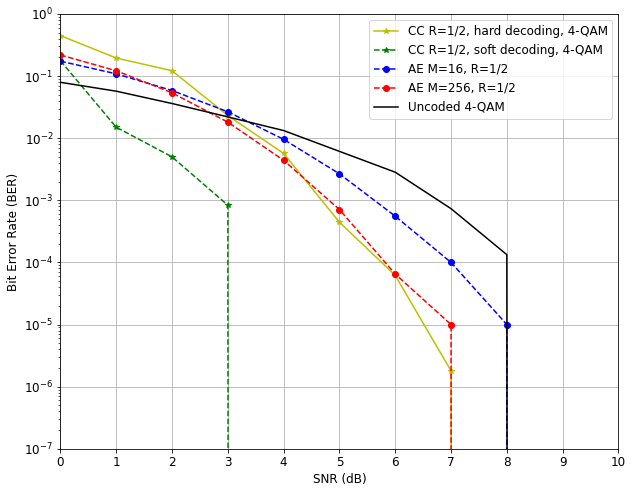

In [ ]:
plt.figure(figsize=(10,8))
plt.xticks(np.arange(min(EbNodB_range), max(EbNodB_range)+1, 1.0))
plt.plot(EbNodB_range, conv_h, 'y*-')
plt.plot(EbNodB_range, conv_s, 'g*--')
plt.plot(EbNodB_range, ae16, 'bo--')
plt.plot(EbNodB_range, ae256, 'ro--')
plt.plot(EbNodB_range, qam4, 'k-')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-7, 1)
plt.xlim(0, 10)
plt.legend(["CC R=1/2, hard decoding, 4-QAM",
            "CC R=1/2, soft decoding, 4-QAM",
            "AE M=16, R=1/2",
            "AE M=256, R=1/2",
            "Uncoded 4-QAM"])
#plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Coded/ber-ratio1-2.png')
#plt.show()

In [ ]:
# Convolutional Block Length Evaluation

conv6 = np.array(conv6mil)
conv2 = np.array(conv2mil)
conv8 = np.array(conv800)
conv4 = np.array(conv400)

ae16 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-48-b2000.npy')[2:]
ae256 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-816-b2000.npy')[2:]

#qam16 = np.array([0.1413, 0.1165, 0.0985, 0.0767, 0.0616, 0.0411, 0.0279, 0.0164, 0.0093, 0.0039, 0.0014])  
qam4 = np.array([[0.079267,    0.057067,    0.036133,       0.022,    0.013267,   0.0061333,   0.0028333,  0.00073333,  0.00013333,    0,    0]]).reshape(11,)
# Gray coding matlab

In [ ]:
EbNodB_range = np.arange(0,11,1)

In [ ]:
plt.rcParams.update({'font.size': 12})

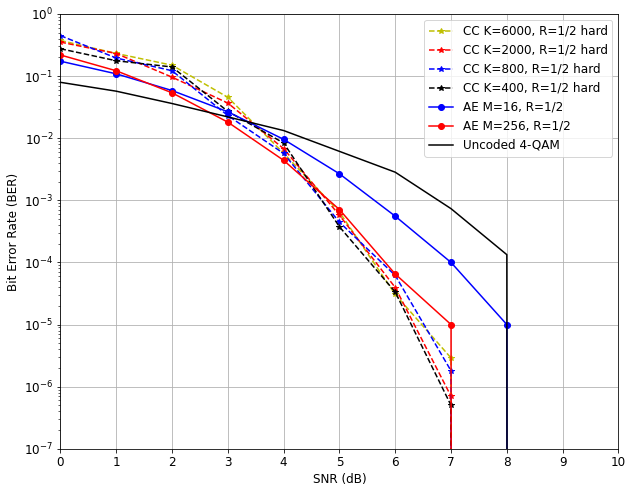

In [ ]:
plt.figure(figsize=(10,8))
plt.xticks(np.arange(min(EbNodB_range), max(EbNodB_range)+1, 1.0))
plt.plot(EbNodB_range, conv6, 'y*--')
plt.plot(EbNodB_range, conv2, 'r*--')
plt.plot(EbNodB_range, conv8, 'b*--')
plt.plot(EbNodB_range, conv4, 'k*--')
plt.plot(EbNodB_range, ae16, 'bo-')
plt.plot(EbNodB_range, ae256, 'ro-')
plt.plot(EbNodB_range, qam4, 'k-')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-7, 1)
plt.xlim([0, 10])
plt.legend(["CC K=6000, R=1/2 hard",
            "CC K=2000, R=1/2 hard",
            "CC K=800, R=1/2 hard",
            "CC K=400, R=1/2 hard",
            "AE M=16, R=1/2",
            "AE M=256, R=1/2",
            "Uncoded 4-QAM"])
#plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Coded/ber-blockEval-ratio1-2.png')
#plt.show()

#R=1/3

In [ ]:
conv_h = np.array(conv800_1o3)
conv_s = np.array(sconv800_1o3)
ae16 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-412-b2000.npy')[2:]
ae256 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-824-b2000.npy')[2:]

#qam16 = np.array([0.1413, 0.1165, 0.0985, 0.0767, 0.0616, 0.0411, 0.0279, 0.0164, 0.0093, 0.0039, 0.0014])  
qam4 = np.array([[0.079267,    0.057067,    0.036133,       0.022,    0.013267,   0.0061333,   0.0028333,  0.00073333,  0.00013333,    0,    0]]).reshape(11,)
# Gray coding matlab

In [ ]:
EbNodB_range = np.arange(0,11,1)

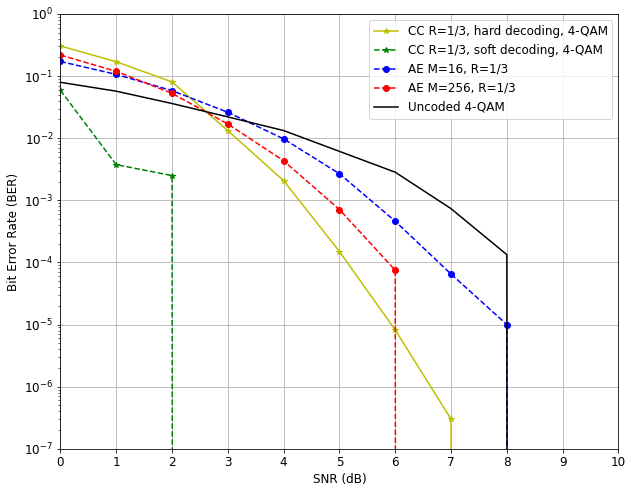

In [ ]:
plt.figure(figsize=(10,8))
plt.xticks(np.arange(min(EbNodB_range), max(EbNodB_range)+1, 1.0))
plt.plot(EbNodB_range, conv_h, 'y*-')
plt.plot(EbNodB_range, conv_s, 'g*--')
plt.plot(EbNodB_range, ae16, 'bo--')
plt.plot(EbNodB_range, ae256, 'ro--')
plt.plot(EbNodB_range, qam4, 'k-')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-7, 1)
plt.xlim(0, 10)
plt.legend(["CC R=1/3, hard decoding, 4-QAM",
            "CC R=1/3, soft decoding, 4-QAM",
            "AE M=16, R=1/3",
            "AE M=256, R=1/3",
            "Uncoded 4-QAM"])
#plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Coded/ber-ratio1-3.png')
#plt.show()

In [ ]:
# Convolutional Block Length Evaluation

conv6 = np.array(conv6_1o3)
conv2 = np.array(conv2_1o3)
conv8 = np.array(conv800_1o3)
conv4 = np.array(conv400_1o3)

ae16 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-412-b2000.npy')[2:]
ae256 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-824-b2000.npy')[2:]

qam16 = np.array([0.1413, 0.1165, 0.0985, 0.0767, 0.0616, 0.0411, 0.0279, 0.0164, 0.0093, 0.0039, 0.0014])  
qam4 = np.array([[0.079267,    0.057067,    0.036133,       0.022,    0.013267,   0.0061333,   0.0028333,  0.00073333,  0.00013333,    0,    0]]).reshape(11,)
# Gray coding matlab

In [ ]:
EbNodB_range = np.arange(0,11,1)

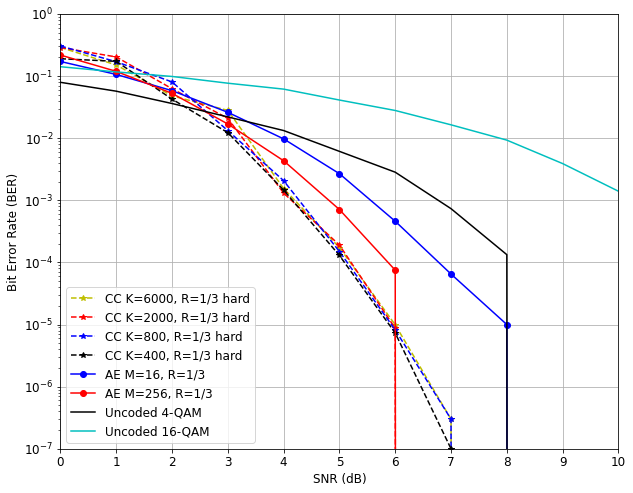

In [ ]:
plt.figure(figsize=(10,8))
plt.xticks(np.arange(min(EbNodB_range), max(EbNodB_range)+1, 1.0))
plt.plot(EbNodB_range, conv6, 'y*--')
plt.plot(EbNodB_range, conv2, 'r*--')
plt.plot(EbNodB_range, conv8, 'b*--')
plt.plot(EbNodB_range, conv4, 'k*--')
plt.plot(EbNodB_range, ae16, 'bo-')
plt.plot(EbNodB_range, ae256, 'ro-')
plt.plot(EbNodB_range, qam4, 'k-')
plt.plot(EbNodB_range, qam16, 'c-')
plt.yscale('log')
plt.grid(True)  
plt.ylim(10**-7, 1)
plt.xlim([0, 10])
plt.legend(["CC K=6000, R=1/3 hard",
            "CC K=2000, R=1/3 hard",
            "CC K=800, R=1/3 hard",
            "CC K=400, R=1/3 hard",
            "AE M=16, R=1/3",
            "AE M=256, R=1/3",
            "Uncoded 4-QAM",
            "Uncoded 16-QAM"])
#plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Coded/ber-blockEval-ratio1-3v2.jpeg')
#plt.show()

# (7,4) Evaluation/Reproduction of O'Shea Figure

In [ ]:
hamminghard = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/bler_Hamming_hard.npy')
hammingmld = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/bler_Hamming_maxLikelihood_all.npy')
ae74 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/ber-74-b2000.npy')[2:]
uncBPSK44 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/Coded-data/bler-bpsk-4-4.npy')

#qam16 = np.array([0.1413, 0.1165, 0.0985, 0.0767, 0.0616, 0.0411, 0.0279, 0.0164, 0.0093, 0.0039, 0.0014])  
#qam4 = np.array([[0.079267,    0.057067,    0.036133,       0.022,    0.013267,   0.0061333,   0.0028333,  0.00073333,  0.00013333,    0,    0]]).reshape(11,)
# Gray coding matlab

In [ ]:
ae74bler = 1 - (1 - ae74)**7

In [ ]:
EbNodB_range = np.arange(0,11,1)

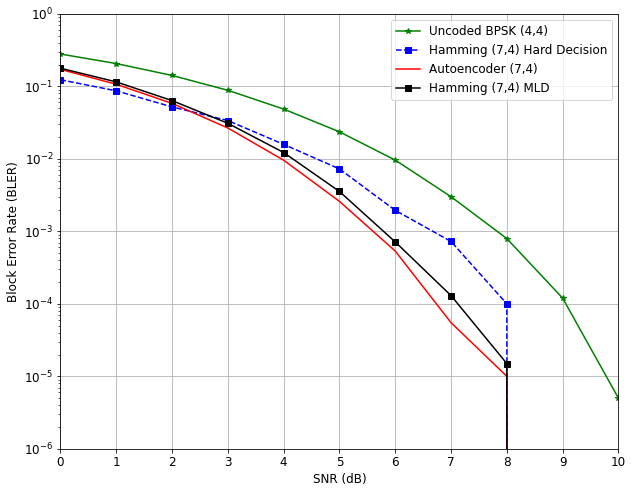

In [ ]:
plt.figure(figsize=(10,8))
plt.xticks(np.arange(min(EbNodB_range), max(EbNodB_range)+1, 1.0))
plt.plot(EbNodB_range, uncBPSK44, 'g*-')
plt.plot(EbNodB_range, ber_hamming, 'bs--')
plt.plot(EbNodB_range, ae74, 'r-')
plt.plot(EbNodB_range, hammingmld, 'ks-')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-6, 1)
plt.xlim(0, 10)
plt.legend(["Uncoded BPSK (4,4)",
            "Hamming (7,4) Hard Decision",
            "Autoencoder (7,4)",
            "Hamming (7,4) MLD"
            ])
#plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Block Error Rate (BLER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Coded/oShea-figure.png')
#plt.show()

#Hamming Hard with Scikit-Dsp-Comm in Python
###https://github.com/mwickert/scikit-dsp-comm

In [ ]:
!git clone https://github.com/mwickert/scikit-dsp-comm.git

Cloning into 'scikit-dsp-comm'...
remote: Enumerating objects: 2623, done.
remote: Counting objects: 100% (374/374), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 2623 (delta 252), reused 267 (delta 171), pack-reused 2249
Receiving objects: 100% (2623/2623), 20.87 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (1734/1734), done.


In [ ]:
import sys
#sys.path.append('./scikit-dsp-comm/')          # change workspace
sys.path.append('./content/')     #change back to upper directory workspace

In [ ]:
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.special as special
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.fec_block as block
import random

In [ ]:
def hamming_7_4_hard():
  # k=4 e n=7
  hh1 = block.FECHamming(3)
  N_blocks_per_frame = 10000
  N_bits_per_frame = N_blocks_per_frame*hh1.k     # 80
  EbN0_db = np.arange(0, 11, 1)        #np.arange(-4, 9, 1)                
  rate_coding = hh1.k/hh1.n
  BER_sim = []

  ## GENERATE RANDOM MESSAGE
  x = np.random.randint(0, 2, N_bits_per_frame)

  ## CODING
  y = hh1.hamm_encoder(x)

  ### MODULATION
  M = 2       # Number of points in BPSK constellation
  m = np.arange(0,M)    #all possible input symbols
  A = 1      #amplitude
  constellation = -A*np.cos(m/M*2*np.pi)  #reference constellation for BPSK
  s = constellation[y.astype(int)] #modulated symbols

  ## ADD NOISE (AWGN)
  for ii in EbN0_db:
    var_noise = 1 / (2* rate_coding * 10 ** (ii / 10))
    yn = s + np.sqrt(var_noise)*np.random.randn(np.size(s))
    #print('yn = \n' + str(yn))

    ## DEMODULATION
    y_demod = ((np.sign(yn)+1)/2).astype(int)
    # print('s = \n' + str(s))
    # print('y_demod = \n' + str(y_demod))

    ## DECODING
    z = hh1.hamm_decoder(y_demod)
    bit_count, bit_errors = dc.bit_errors(x,z)

    BER_sim.append(bit_errors/bit_count)


  return EbN0_db, BER_sim


SNR, ber_hamming = hamming_7_4_hard()

# **COMPARISONS (BPSK, QPSK)**

In [ ]:

def bpsk_encode(int_bit):
    if(int_bit == 0):
        return -1
    elif(int_bit == 1):
        return 1
    else:
        assert(False)
bpsk_encode_vec = np.vectorize(bpsk_encode)


def bpsk_decode(float_bit):
    if(float_bit <= 0.):
        return 0
    elif(float_bit > 0.):
        return 1
    else:
        assert(False)
bpsk_decode_vec = np.vectorize(bpsk_decode)


def get_noise_sigma(Eb_N0_db, Rr=None, Rc=None):
    assert(not((Rr == None)&(Rc == None)))
    if(Rr == None):
        Rr = Rc/2.
    Eb_N0 = 10.**(Eb_N0_db/10.)
    return np.sqrt(1./(2.*Rr*Eb_N0))

def get_block_error_rate(test_data, pred_symbs):
    errors = (test_data != pred_symbs)
    block_errors = errors.any(axis=1)
    return block_errors.sum()/block_errors.shape[0]

def bpsk_get_bler(std, test_data):
    # Encode into bpsk
    bpsk_encoded = bpsk_encode_vec(test_data)
    # Add AWGN noise
    noise = std * np.random.randn(bpsk_encoded.shape[0],\
                                  bpsk_encoded.shape[1])
    received = bpsk_encoded + noise
    # Decode from bpsk back to bits
    bpsk_decoded = bpsk_decode_vec(received)

    # Get Block error rate
    return get_block_error_rate(test_data, bpsk_decoded)



In [ ]:
# (8,8)
t0 = time()
Eb_N0_dbs = np.arange(-2, 16.0, 1)
bler_bpsk88 = np.empty(Eb_N0_dbs.size)
for i, ratio_db in enumerate(tqdm_notebook(Eb_N0_dbs, desc="1st loop")):
#     print(f"ratio_db = {ratio_db}, i = {i}/{Eb_N0_dbs.size}")
    ## Get noise std_dev 
    noise_std = get_noise_sigma(ratio_db, Rr=1)
    # Encode, add noise and decode data, then get BLER
    bler_bpsk88[i] = bpsk_get_bler(noise_std, test_data44)
print(f"Took {time() - t0}")




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


1st loop:   0%|          | 0/18 [00:00<?, ?it/s]

Took 21.231407165527344


In [ ]:
with open('./drive/MyDrive/Colab_Notebooks/data/bpsk44_ber_neg2_to_15.npy', 'wb') as f:
  np.save(f, bler_bpsk88)

In [ ]:
bpsk22 = np.load('./drive/MyDrive/Colab_Notebooks/data/bpsk22_4_bler_neg2_to_15.npy')
bpsk88 = np.load('./drive/MyDrive/Colab_Notebooks/data/bpsk88_256_bler_neg2_15.npy')
bpsk44 = np.load('./drive/MyDrive/Colab_Notebooks/data/bpsk44_ber_neg2_to_15.npy')

In [ ]:
random = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-snrRandom-44.npy')
var = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-snrVar-44-10eps.npy')
fixa = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-44-5-b2000.npy')
# s15 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-15-b2000.npy')
# s20 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-20-b2000.npy')

In [ ]:
QPSK_sim = [1.3007e-01, 1.0367e-01, 7.7570e-02, 5.6430e-02, 3.6810e-02, 2.3200e-02,
 1.2440e-02, 5.6700e-03, 2.2800e-03, 9.4000e-04, 1.8000e-04, 1.0000e-05,
 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]

QPSK_teorico = [1.30644489e-01, 1.03759096e-01, 7.86496035e-02, 5.62819520e-02,
 3.75061284e-02, 2.28784076e-02, 1.25008180e-02, 5.95386715e-03,
 2.38829078e-03, 7.72674815e-04, 1.90907774e-04, 3.36272284e-05,
 3.87210822e-06, 2.61306795e-07, 9.00601035e-09, 1.33293102e-10,
 6.81018913e-13, 9.12395736e-16]

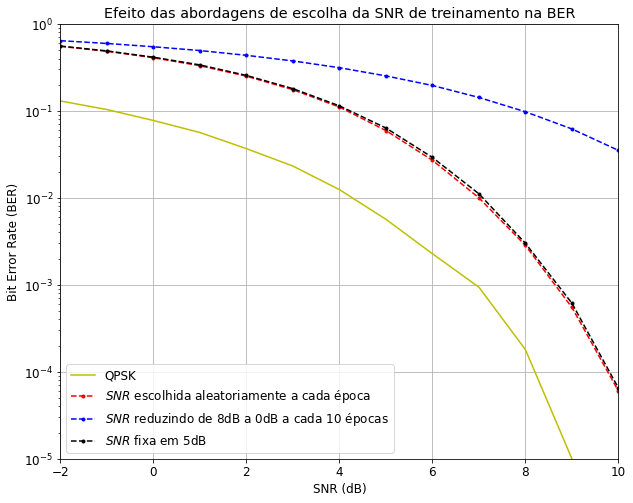

In [ ]:
EbNodB_range = np.arange(-2,16,1)

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, QPSK_sim, 'y-')
plt.plot(EbNodB_range, random, 'r.--')
plt.plot(EbNodB_range, var, 'b.--')
plt.plot(EbNodB_range, fixa, 'k.--')
# plt.plot(EbNodB_range, s15.reshape(13,), 'g.--')
# plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-5, 1)
plt.xlim(-2, 10)
plt.legend(["QPSK",
            "$SNR$ escolhida aleatoriamente a cada época",
            "$SNR$ reduzindo de 8dB a 0dB a cada 10 épocas",
            "$SNR$ fixa em 5dB"]) #,]
            # "AE $SNR_{treino}$=15dB",
            # "AE $SNR_{treino}$=20dB"])
plt.title("Efeito das abordagens de escolha da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
#plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/approaches-snr-44.png')
plt.show()

In [ ]:
sn2 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-neg2-b2000.npy')
s5 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-5-b2000.npy')
s7 = np.load('./drive/MyDrive/Colab_Notebooks/data/m-evaluation-88-snr7-b2000.npy')
s15 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-15-b2000.npy')
s20 = np.load('./drive/MyDrive/Colab_Notebooks/data/snr-eval-88-20-b2000.npy')

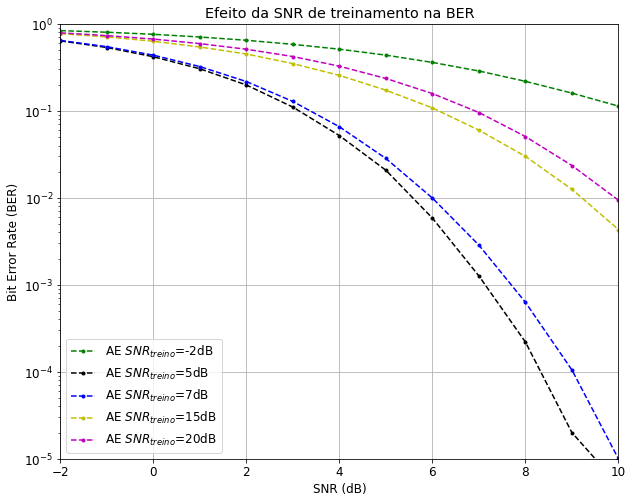

In [ ]:
EbNodB_range = np.arange(-2,11,1)

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, sn2.reshape(13,), 'g.--')
plt.plot(EbNodB_range, s5.reshape(13,), 'k.--')
plt.plot(EbNodB_range, s7.reshape(13,), 'b.--')
plt.plot(EbNodB_range, s15.reshape(13,), 'y.--')
plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-5, 1)
plt.xlim(-2, 10)
plt.legend(["AE $SNR_{treino}$=-2dB",
            "AE $SNR_{treino}$=5dB",
            "AE $SNR_{treino}$=7dB",
            "AE $SNR_{treino}$=15dB",
            "AE $SNR_{treino}$=20dB"])
plt.title("Efeito da SNR de treinamento na BER")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/snr-eval-88-fig.png')
#plt.show()

In [ ]:
z2000 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-44-5-b2000.npy')
z1000 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-44-5-b1000.npy')
z100 = np.load('./drive/MyDrive/Colab_Notebooks/dataV2/ber-44-5-b100.npy')

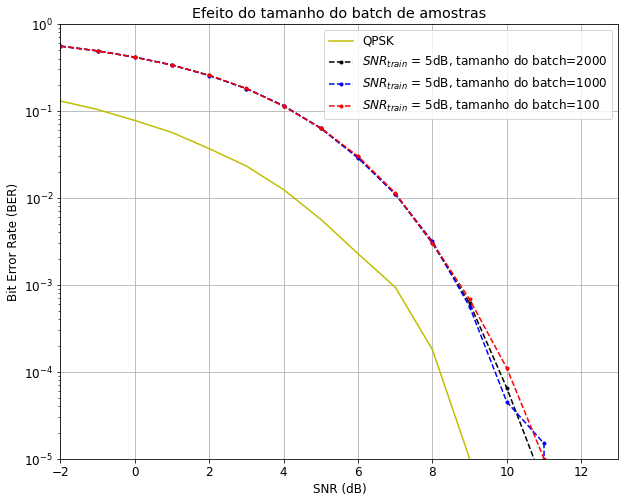

In [ ]:
EbNodB_range = np.arange(-2,16,1)

plt.figure(figsize=(10,8))
plt.plot(EbNodB_range, QPSK_sim, 'y-')
plt.plot(EbNodB_range, z2000, 'k.--')
plt.plot(EbNodB_range, z1000, 'b.--')
plt.plot(EbNodB_range, z100, 'r.--')
# plt.plot(EbNodB_range, s15.reshape(13,), 'g.--')
# plt.plot(EbNodB_range, s20.reshape(13,), 'm.--')
plt.yscale('log')
plt.grid(True)
plt.ylim(10**-5, 1)
plt.xlim(-2, 13)
plt.legend(["QPSK",
            "$SNR_{train}$ = 5dB, tamanho do batch=2000",
            "$SNR_{train}$ = 5dB, tamanho do batch=1000",
            "$SNR_{train}$ = 5dB, tamanho do batch=100"]) #,]
            # "AE $SNR_{treino}$=15dB",
            # "AE $SNR_{treino}$=20dB"])
plt.title("Efeito do tamanho do batch de amostras")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/batch-choice-44.png')
plt.show()

# **CONSTELAÇÃO**

In [ ]:
# Number of messages  (4 [2,2], 16 [4,4], 256 [8,8])
M = 16 
k = np.log2(M) #2
k = int(k)
tx_power = 2
# Channel uses
n = 4 
R = k/n      
n_channel = k/R    #np.log2(M)/R   # channel uses = log2(M)/R

#ae = load_model('./drive/MyDrive/Colab_Notebooks/modelsV2/ae21_7_b2000.model')
#ae.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/ae21_7_b2000.h5')

In [ ]:
ae.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_16 (Dense)            (None, 4)                 20        
                                                                 
 dense_17 (Dense)            (None, 2)                 10        
                                                                 
 batch_normalization_4 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
 lambda_4 (Lambda)           (None, 2)                 0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 2)                0         
 oise)                                                     

In [ ]:
# scatter_plot = []
# for i in range(0,M):
#     temp = np.zeros(M)
#     temp[i] = 1

ae22_, tx22, rx22 = make_model(16, 7)
ae22_.load_weights('./drive/MyDrive/Colab_Notebooks/modelsV2/ae44_7_b2000.h5')

scatter_plot = tx22.predict(test_data44)      #np.expand_dims(temp, axis=0)
#scatter_plot = 1.5/2*scatter_plot
print(scatter_plot.shape)

(200000, 8)


In [ ]:
fpar = np.unique(scatter_plot[:,0])
spar = np.unique(scatter_plot[:,2])
fimp = np.unique(scatter_plot[:,1])
simp = np.unique(scatter_plot[:,3])

In [ ]:
print(fpar)
print(spar)
print(fimp)
print(simp)

[-0.95538604 -0.6211899   0.69072884  0.90176773]
[-0.5797093 -0.5554615  0.4309905  0.7024548]
[-0.9347577  -0.639534    0.70505154  0.9140712 ]
[-0.68503565 -0.5040601   0.49689883  0.7082474 ]


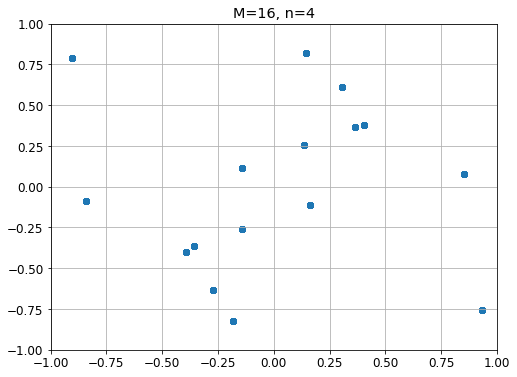

In [ ]:
# ploting constellation diagram
import matplotlib.pyplot as plt
#scatter_plot = scatter_plot.reshape(M,2,1)
plt.figure(figsize=(8,6))
plt.scatter(scatter_plot[:,0], scatter_plot[:,1])
plt.axis((-1.0,1.0,-1.0,1.0))
plt.grid()
plt.title('M=16, n=4')
#plt.xlabel('I Axis')
#plt.ylabel('Q Axis')
plt.show()
#plt.savefig('./drive/MyDrive/Colab_Notebooks/figures/Uncoded/const-m16-n4-symb1.png')

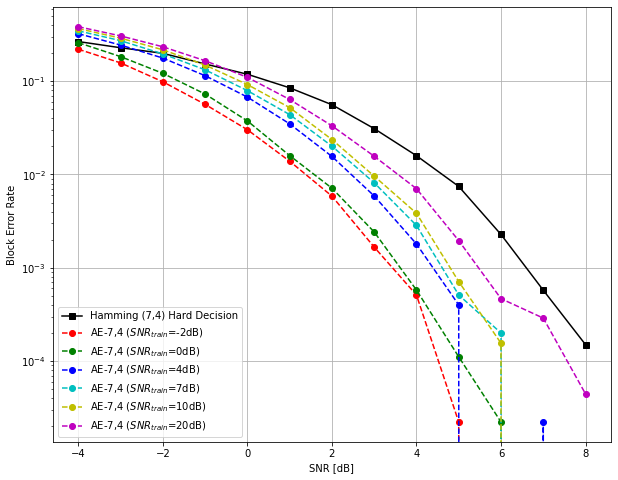

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(SNR, ber_hamming, ls = '-', c = 'k', marker='s')
plt.semilogy(EbNodB_range, ber_array_various_snrs[0], ls = '--', c = 'r', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[1], ls = '--', c = 'g', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[2], ls = '--', c = 'b', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[3], ls = '--', c = 'c', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[4], ls = '--', c = 'y', marker = 'o')
plt.semilogy(EbNodB_range, ber_array_various_snrs[5], ls = '--', c = 'm', marker = 'o')
#plt.plot(list(EbNodB_range), ber_theory, 'ro-',label='BPSK BER')
#plt.yscale('log')
plt.xlabel('SNR [dB]')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(['Hamming (7,4) Hard Decision', 
            'AE-7,4 ($SNR_{train}$=-2dB)', 
            'AE-7,4 ($SNR_{train}$=0dB)', 
            'AE-7,4 ($SNR_{train}$=4dB)', 
            'AE-7,4 ($SNR_{train}$=7dB)', 
            'AE-7,4 ($SNR_{train}$=10dB)', 
            'AE-7,4 ($SNR_{train}$=20dB)'], loc = 'lower left')
#plt.legend(loc='lower left', ncol = 1)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
x_emb = encoder.predict(test_data[0:10000])
noise_std = np.sqrt(1/(2*R*EbNo_train))
noise = noise_std * np.random.randn(10000,n_channel)
x_emb = x_emb + noise

X_embedded = TSNE(learning_rate=750, n_components=2, n_iter=5000, random_state=0, perplexity=60).fit_transform(x_emb)
print(X_embedded.shape)
X_embedded = X_embedded/7

plt.scatter(X_embedded[:,0],X_embedded[:,1])
plt.axis((-2.5,2.5,-2.5,2.5)) 
plt.grid()
plt.show()